# GAN 

Our goal is to create a GAN to color black and white images. For this, we will use the ImageNet database.

In [1]:
import torch
import torch.nn as nn

from torchsummary import summary

import matplotlib.pyplot as plt
import numpy as np

## Model

For the purpose of pix2pix, the generator will follow an encoder-decoder architecture. The discriminator has to be adapted for a binary classification (Fake or Real).  
  

### Generator

In [2]:
import torch.nn.functional as functionnal

In [3]:
class Conv_x2(nn.Module):

    def __init__(self, in_channels, out_channels, dropout=False, dropout_val=0):
        super().__init__()
        self.in_channels  = in_channels
        self.out_channels = out_channels
        self.dropout      = dropout
        self.dropout_val  = dropout_val

        self.conv_x2 = nn.Sequential()
        prev_channels = self.in_channels

        for i in range(2):

            self.conv_x2.append(nn.Conv2d(prev_channels, self.out_channels, kernel_size=3, padding=1))
            self.conv_x2.append(nn.BatchNorm2d(self.out_channels))

            if dropout:
                self.conv_x2.append(nn.Dropout2d(p=dropout_val, inplace=True))

            self.conv_x2.append(nn.LeakyReLU(inplace=True))
            prev_channels = self.out_channels

    def forward(self, x):
        return self.conv_x2(x)

In [4]:
class Block_down_unet(nn.Module):

    def __init__(self, in_channels, out_channels, dropout=False, dropout_val=0):
        super().__init__()
        self.in_channels  = in_channels
        self.out_channels = out_channels
        self.dropout      = dropout
        self.dropout_val  = dropout_val

        self.block = nn.Sequential (
            nn.AvgPool2d(kernel_size=2),
            Conv_x2(self.in_channels, self.out_channels, self.dropout, self.dropout_val)
        )

    def forward(self, x):
        return self.block(x)

In [5]:
class Block_up_unet(nn.Module):

    def __init__(self, in_channels, out_channels, dropout=False, dropout_val=0):
        super().__init__()
        self.in_channels  = in_channels
        self.out_channels = out_channels
        self.dropout      = dropout
        self.dropout_val  = dropout_val
        
        self.upsampling   = nn.ConvTranspose2d(self.in_channels, out_channels = self.in_channels // 2, kernel_size=2, stride=2)
        self.conv_x2      = Conv_x2(self.in_channels, self.out_channels, self.dropout, self.dropout_val)

    def forward(self, x, concat_tensor):

        x = self.upsampling(x)

        diffH = concat_tensor.size()[2] - x.size()[2]
        diffW = concat_tensor.size()[3] - x.size()[3]

        x = functionnal.pad(x, [diffW // 2, diffW - diffW // 2,
                                diffH // 2, diffH - diffH // 2])

        x_res = torch.cat([concat_tensor, x], dim=1)

        return self.conv_x2(x_res)
        

In [6]:
class UNet(nn.Module):

    def __init__(self, n_in_channels, n_out_channels, depth, **kwargs):
        super().__init__()

        self.n_in_channels  = n_in_channels
        self.n_out_channels = n_out_channels
        self.mid_channels_list = [32 * 2**i for i in range(depth + 1)]
        self.down_part = nn.ModuleList()
        self.up_part   = nn.ModuleList()

        if 'dropout' in kwargs:
            self.dropout = kwargs.get('dropout')
        else:
            self.dropout = False
        if 'dropout_val' in kwargs:
            self.dropout_val = kwargs.get('dropout_val')
        else:
            self.dropout_val = 0.5

        self.input_layer  = Conv_x2(self.n_in_channels, self.mid_channels_list[0])
        self.output_layer = Conv_x2(self.mid_channels_list[0], self.n_out_channels) 

        # Encoder path
        for i in range(depth):
            self.down_part.append(
                Block_down_unet(self.mid_channels_list[i], self.mid_channels_list[i + 1])
            )
        # Up path
        for i in reversed(range(depth)):
            self.up_part.append(
                Block_up_unet(self.mid_channels_list[i + 1], self.mid_channels_list[i], dropout=self.dropout, dropout_val=self.dropout_val)
            )

    def forward(self, x):

        down_block_outputs = []

        # First layer
        x = self.input_layer(x)
        down_block_outputs.append(x)
        
        # Encoder path
        for i, down_layer in enumerate(self.down_part):
            x = down_layer(x)
            down_block_outputs.append(x)            
        
        # Decoder path with res path
        for i, up_layer in enumerate(self.up_part, start=1):
            x = up_layer(x, down_block_outputs[-i - 1])
        

        return self.output_layer(x)


### Discriminator

In [7]:
class LeNet_5(torch.nn.Module):

    def __init__(self, in_channels, n_classes):
        #Heritage from nn.Module
        super(LeNet_5, self).__init__()

        self.in_channels = in_channels

        #Features extractor part
        self.feat_extractor_part = torch.nn.Sequential(
            #Conv2D
            torch.nn.Conv2d(in_channels=self.in_channels, out_channels=6, kernel_size=5, padding=1, stride=1, bias=True),
            torch.nn.ReLU(),
            #Sub-Sampling (average pooling)
            torch.nn.AvgPool2d(kernel_size=(2,2), stride=2, padding=0),
            #Conv2D
            torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=(5,5), padding=0, stride=1, bias=True),
            torch.nn.ReLU(),
            #Sub-Sampling (average pooling)
            torch.nn.AvgPool2d(kernel_size=(2,2), stride=2, padding=1),
            #Conv2D
            torch.nn.Conv2d(in_channels=16, out_channels=120, kernel_size=(5,5), padding=0, stride=1, bias=True),
            torch.nn.ReLU(),
            torch.nn.AvgPool2d(kernel_size=(2,2), stride=2, padding=0),
        )

        self.classification_part = torch.nn.Sequential(
            #Fully connected
            torch.nn.Linear(in_features = 120, out_features=64),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(in_features=64, out_features=n_classes),
            torch.nn.Softmax(dim=1),
        )

    def forward(self, x):

        #Extractor
        x = self.feat_extractor_part(x)
        #Reshape
        x = torch.flatten(x, 1)
        #Classification
        x = self.classification_part(x)
        
        return x

In [8]:
class PatchDiscriminator(nn.Module):

    def __init__(self):
        raise NotImplemented

    def forward(self, x):
        raise NotImplemented

## Trainer

In [9]:
from torch.utils.data import DataLoader
import pickle as pkl

In [10]:
class GANTrainer:

    def __init__(self, generator, discriminator, 
                 train_dataset, test_dataset,
                 optimizer_D, optimizer_G,
                 loss_fn, lambda_reg,
                 device):

        self.device = device

        if next(generator.parameters()).device != self.device:
            self.generator = generator.to(self.device)
        else:
            self.generator = generator
        
        if next(discriminator.parameters()).device != self.device:
            self.discriminator = discriminator.to(self.device)
        else:
            self.discriminator = discriminator
        
        self.train_set = train_dataset
        self.test_set  = test_dataset

        self.optimizer_D = optimizer_D
        self.optimizer_G = optimizer_G

        self.loss_fn = loss_fn
        self.lambda_reg = lambda_reg
        #self.metric = metric

    def get_dataloader(self, train=True, **kwargs) -> DataLoader:

        if 'batch_size' in kwargs:
            _batch_size = kwargs.get('batch_size')
        else:
            _batch_size = 32
            
        if 'shuffle' in kwargs:
            _shuffle = kwargs.get('shuffle')
        else:
            _shuffle = True

        if train:
            if self.train_set is None:
                raise ValueError("Trainer: training requires a train_dataset.")
            else:
                return DataLoader(self.train_set, shuffle=_shuffle, batch_size=_batch_size)
        else:
            if self.test_set is None:
                raise ValueError("Trainer: training requires a test dataset.")
            else:
                return DataLoader(self.test_set, shuffle=_shuffle, batch_size=_batch_size)

    def D_train_step(self, train_loader):

        running_loss = 0.0

        self.discriminator.train()
        self.generator.train()

        for _, data in enumerate(train_loader):
            
            self.optimizer_D.zero_grad()
            
            # Fake image + associated loss
            fake_abs     = self.generator(data['L'])
            fake_img     = torch.cat([data['L'], fake_abs], dim=1)
            pred_fake    = self.discriminator(fake_img)
            loss_on_fake = self.loss_fn(pred_fake, torch.ones(pred_fake.shape).type(torch.float32).to(self.device))

            # Real image + associated loss
            real_img     = torch.cat([data['L'], data['ab']], dim=1)
            pred_real    = self.discriminator(real_img)
            loss_on_real = self.loss_fn(pred_real, torch.zeros(pred_fake.shape).type(torch.float32).to(self.device))

            total_loss = loss_on_fake + loss_on_real
            total_loss.backward()

            self.optimizer_D.step()

            running_loss += total_loss.item()
        
        return running_loss

    
    def G_train_step(self, train_loader):

        running_loss = 0.0
        self.generator.train()

        for _, data in enumerate(train_loader):

            self.optimizer_G.zero_grad()

            fake_abs = self.generator(data['L'])
            fake_img = torch.cat([data['L'], fake_abs], dim=1)

            fake_pred = self.discriminator(fake_img)

            loss_G_GAN = self.loss_fn(fake_pred, torch.ones(fake_pred.shape).type(torch.float32).to(self.device))
            loss_L1    = nn.L1Loss(reduction='sum')(fake_abs, data['ab'])
            
            loss = loss_G_GAN + loss_L1 * self.lambda_reg
            loss.backward()

            self.optimizer_G.step()

            running_loss += loss.item()

        return running_loss
    
    def train(self, train_loader, test_loader, n_epochs, 
              file_path_save_discriminator, file_path_save_generator,
              save_epoch_path, results_file_path):
        """
            Main training entry point.
        """
        print("Starting training...\n")
        print("The model will be running on", next(self.generator.parameters()).device, "device.\n")
        
        results       = []

        for epoch in range(1, n_epochs+1):

            d_train_loss     = 0.0
            g_train_loss     = 0.0

            ### Training

            # Discriminator training
            d_train_loss = self.D_train_step(train_loader)
        
            # Generator training
            g_train_loss = self.G_train_step(train_loader) + d_train_loss

            print(f'Epoch: {epoch}, discriminator train loss: {d_train_loss:.4f}, generator train loss: {g_train_loss:.4f}')

            results.append((d_train_loss, g_train_loss))

        # Saving model
        print('Saving the models...\n')
        self.discriminator = self.discriminator.to('cpu')
        self.generator     = self.generator.to('cpu')
        self.save_model(file_path_save_discriminator, file_path_save_generator)

        # Saving the performances
        with open(results_file_path, 'wb') as f:
            pkl.dump(results, f) 

        print("Training finish.\n") 

        return self.discriminator, self.generator


    def save_model(self, d_file_path, g_file_path):
        """
            Function to save model's parameters
        """
        torch.save(self.discriminator.state_dict(), d_file_path)
        torch.save(self.generator.state_dict(), g_file_path)

            

## Data

In [11]:
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torchvision.transforms import transforms

from skimage import color

In [12]:
class colorCIFAR10(datasets.CIFAR10):

    def __init__(self, root='', train=True, download=True, transform=None):
        super().__init__(root, train, download)
        self.transform = transform

    def __getitem__(self, idx):

        image, _ = super().__getitem__(idx)
        # PIL to numpy array + Normalization
        image = np.array(image)/255.
        # from RGB to Lab
        image = color.rgb2lab(image)

        # from numpy array to Tensor
        image = transforms.ToTensor()(image)

        # scaling to [-1 ; 1]
        L  = image[0,:,:] / 100. - 1
        ab = image[1:3,:,:] / 128.

        # convert to float32
        L  = L.type(torch.cuda.FloatTensor).unsqueeze(0)
        ab = ab.type(torch.cuda.FloatTensor)

        return {'L' : L, 'ab' : ab}


def create_dataloader(dataset, **kwargs):

    if "shuffle" in kwargs:
        _shuffle    = kwargs.get('shuffle')
    else:
        _shuffle = True
    if "batch_size" in kwargs:
        _batch_size = kwargs.get('batch_size')
    else:
        _batch_size = 32
    
    return DataLoader(dataset, shuffle=_shuffle, batch_size=_batch_size)
 

In [13]:
trainset = datasets.CIFAR10(root='./data', train=True, download=True)
testset  = datasets.CIFAR10(root='./data', train=False, download=True)

trainset = colorCIFAR10(root='./data', train=True, download=True)
testset  = colorCIFAR10(root='./data', train=False, download=True)

train_loader = create_dataloader(trainset, shuffle=True, batch_size=32)
test_loader  = create_dataloader(testset, shuffle=False, batch_size=32)


Files already downloaded and verified
Files already downloaded and verified


Info of train dataset
dict_keys(['root', 'transform', 'target_transform', 'transforms', 'train', 'data', 'targets', 'classes', 'class_to_idx'])
Number of data: 50000
Shape of data: (32, 32, 3)

Median:	 [123.0, 121.0, 104.0]
Mean:	 [125.306918046875, 122.950394140625, 113.86538318359375]
Std:	 [62.993219278136884, 62.08870764001421, 66.70489964063091]


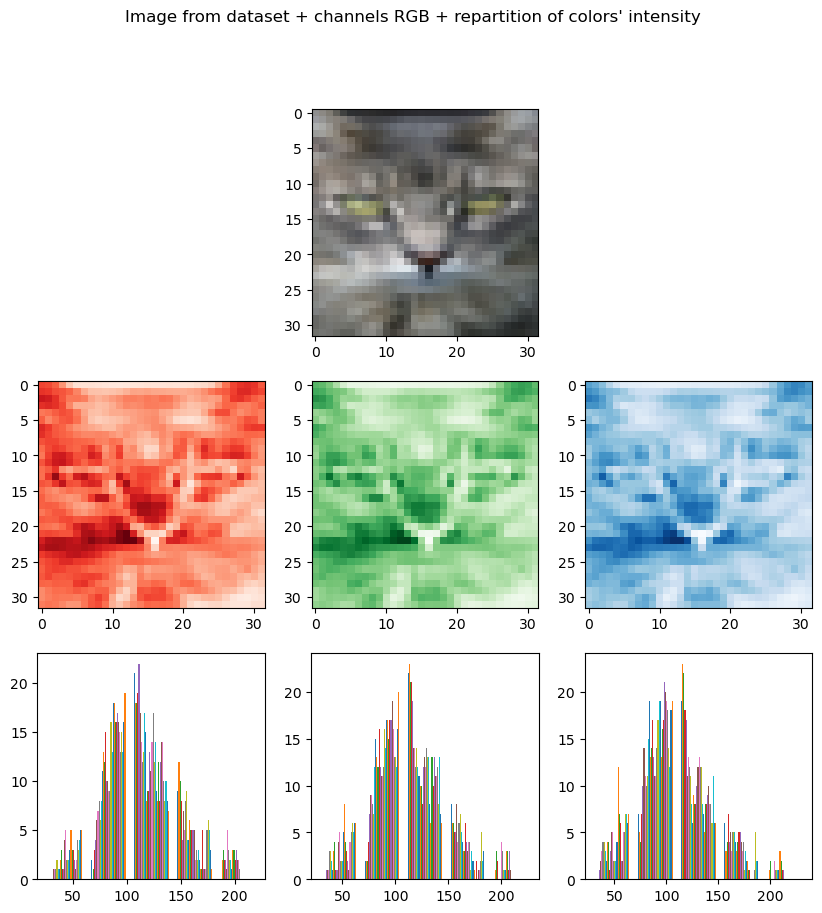

Info of eval dataset
dict_keys(['root', 'transform', 'target_transform', 'transforms', 'train', 'data', 'targets', 'classes', 'class_to_idx'])
Number of data: 10000
Shape of data: (32, 32, 3)

Median:	 [124.0, 121.0, 105.0]
Mean:	 [126.02464140625, 123.70850419921875, 114.85431865234375]
Std:	 [62.89639134921991, 61.93752718231365, 66.70605639561605]


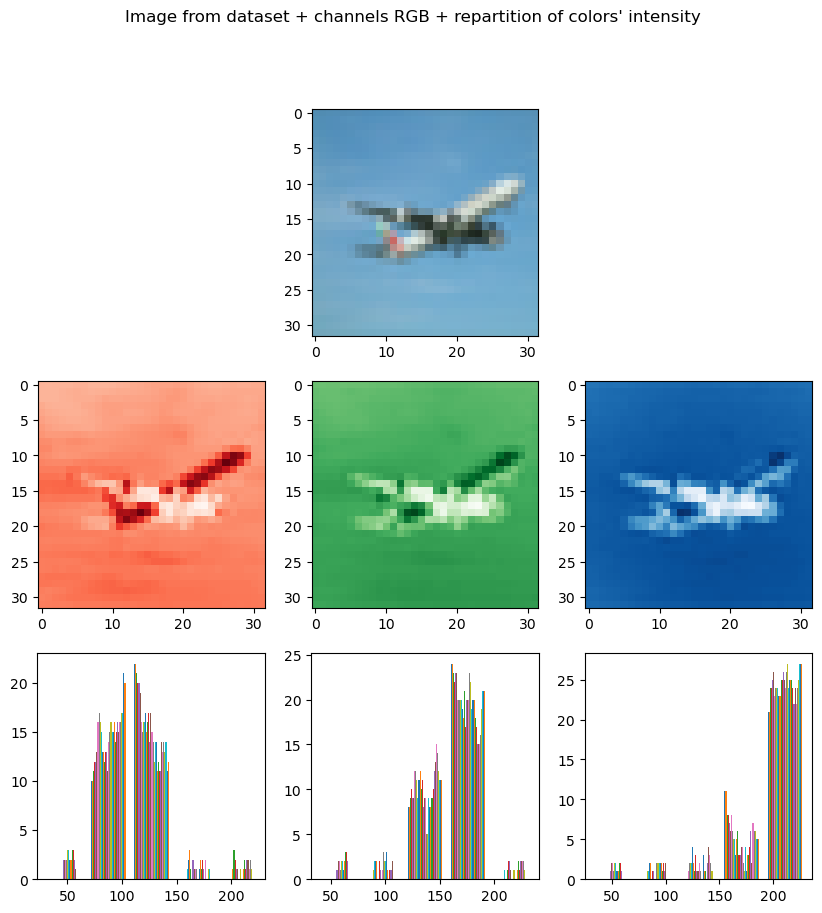

In [14]:
def get_data_info(dataset):
    """
        Get essential info 
    """
    # All atributes of the dataset
    print(dataset.__dict__.keys())
    # Numbers of element
    print(f"Number of data: {dataset.data.shape[0]}")
    # Shape of data
    print(f"Shape of data: {dataset.data.shape[1:]}\n")



def plot_image_RGB(dataset, image_idx):

    image = dataset.data[image_idx]

    fig, axs = plt.subplots(3,3, figsize=(10,10))
    channels = ['Reds', 'Greens', 'Blues']

    # Ground truth image
    axs[0,1].imshow(image)
    axs[0,0].axis('off')
    axs[0,2].axis('off')

    for i in range(3):
        # Display channel
        axs[1,i].imshow(image[:,:,i], cmap=channels[i])
        # Display hist of the channel
        axs[2,i].hist(image[:,:,i], bins=5)

    fig.suptitle("Image from dataset + channels RGB + repartition of colors' intensity")

    plt.show()



def get_stats(dataset):
    """
        Get statistical info on the dataset for each channel (RGB)
    """

    median = []
    mean   = []
    std    = []

    for i in range(3):
        median.append(np.median(dataset.data[:,:,:,i]))
        mean.append(np.mean(dataset.data[:,:,:,i]))
        std.append(np.std(dataset.data[:,:,:,i]))

    return median, mean, std



############################################

print("Info of train dataset")

get_data_info(trainset)

median, mean, std = get_stats(trainset)

print(f'Median:\t {median}')
print(f'Mean:\t {mean}')
print(f'Std:\t {std}')

plot_image_RGB(trainset, 8000)

#############################################
print("Info of eval dataset")

get_data_info(testset)

median, mean, std = get_stats(testset)

print(f'Median:\t {median}')
print(f'Mean:\t {mean}')
print(f'Std:\t {std}')
plot_image_RGB(testset, 1010)

## Utils

## Main

In [15]:
from torchmetrics import Dice

In [16]:
def main():
    
    #generator = UNet(1, 2, 3)
    # summary(unet, (1,32,32))

    #discriminator = LeNet_5(in_channels=2, n_classes=2)
    # summary(discriminator, (2,32,32))

    # Load the data
    trainset = colorCIFAR10(root='./data', train=True, download=True)
    testset  = colorCIFAR10(root='./data', train=False, download=True)

    # train_loader = create_dataloader(trainset, shuffle=True, batch_size=32)
    # test_loader  = create_dataloader(testset, shuffle=False, batch_size=32)

    # Models
    depth = 3
    generator     = UNet(n_in_channels=1, n_out_channels=2, depth=depth)    
    discriminator = LeNet_5(in_channels=3, n_classes=2)

    # Dataloaders
    

    # Trainer (set hyperparams)
    d_lr = 0.02
    d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=d_lr)
    g_lr = 0.02
    g_optimizer = torch.optim.Adam(generator.parameters(), lr=g_lr)
    loss_fn = nn.BCEWithLogitsLoss()
    device = 'cuda:0' 

    trainer = GANTrainer(generator=generator, discriminator=discriminator,
                         train_dataset=trainset, test_dataset=testset, 
                         optimizer_D=d_optimizer, optimizer_G=g_optimizer, 
                         loss_fn=loss_fn, lambda_reg=1.,
                         device=device
                         )

    # Dataloaders 
    train_loader = trainer.get_dataloader(train=True, shuffle=True, batch_size=32)
    test_loader  = trainer.get_dataloader(train=False, shuffle=True, batch_size=32) 

    # Set hyper params
    n_epochs = 150
    file_path_save_discriminator = "./saving/test_trained_discriminator.pth"
    file_path_save_generator     = "./saving/test_trained_generator.pth"
    save_epoch_path      = "./saving/test_epochs.pth"
    results_file_path    = "./saving/test_results.pth"

    trainer.train(train_loader=train_loader, test_loader=test_loader, 
                  n_epochs=n_epochs, 
                  file_path_save_discriminator=file_path_save_discriminator, file_path_save_generator= file_path_save_generator,
                  save_epoch_path=save_epoch_path, results_file_path=results_file_path
                  )
    

In [17]:
if __name__ == "__main__":
    
    main()

Starting training...

The model will be running on cuda:0 device.

Epoch: 1, discriminator train loss: 2263.5153, generator train loss: 7249696.6222
Epoch: 2, discriminator train loss: 2263.4647, generator train loss: 6851264.8443
Epoch: 3, discriminator train loss: 2263.4647, generator train loss: 6798600.0592
Epoch: 4, discriminator train loss: 2263.4647, generator train loss: 6773273.8895
Epoch: 5, discriminator train loss: 2263.4647, generator train loss: 6752813.3961
Epoch: 6, discriminator train loss: 2263.4647, generator train loss: 6744394.7464
Epoch: 7, discriminator train loss: 2263.4647, generator train loss: 6732921.8746
Epoch: 8, discriminator train loss: 2263.4647, generator train loss: 6700490.9024
Epoch: 9, discriminator train loss: 2263.4647, generator train loss: 6683445.4102
Epoch: 10, discriminator train loss: 2263.4647, generator train loss: 6687390.8707
Epoch: 11, discriminator train loss: 2263.4647, generator train loss: 6678204.6779
Epoch: 12, discriminator trai

## Training analysis

In [18]:
def load_results_pkl(pkl_file_path):

    pkl_file = pkl.load(open(pkl_file_path, 'rb'))
    
    d_loss = list()
    g_loss = list()

    for d_train_loss, g_train_loss in pkl_file:
        d_loss.append(d_train_loss)
        g_loss.append(g_train_loss)

    return d_loss, g_loss

In [29]:
def plot_performances(d_loss, g_loss, save=True):

    fig, (ax0, ax1) = plt.subplots(1,2, sharex=True, figsize=(15,5))

    ax0.set_title("Evolution of the Discriminator loss")
    ax0.plot([i+1 for i in range(len(d_loss))], d_loss)
    ax0.set_xticks([i+1 for i in range(len(d_loss)) if (i+1)%10 == 0])
    ax0.set_xlabel("Epoch index")
    ax0.set_ylabel("Loss")
    ax0.grid()
    
    ax1.set_title("Evolution of the accuracy")
    ax1.plot([i+1 for i in range(len(g_loss))], g_loss)
    ax1.set_xticks([i+1 for i in range(len(g_loss)) if (i+1)%10 == 0])
    ax1.set_xlabel("Epoch index")
    ax1.set_ylabel("Accuracy")
    ax1.grid()

    suptitle = "Performances of the cGAN"
    fig.suptitle(suptitle)

    if save:
        plt.savefig(suptitle + ".pdf")

    plt.show()


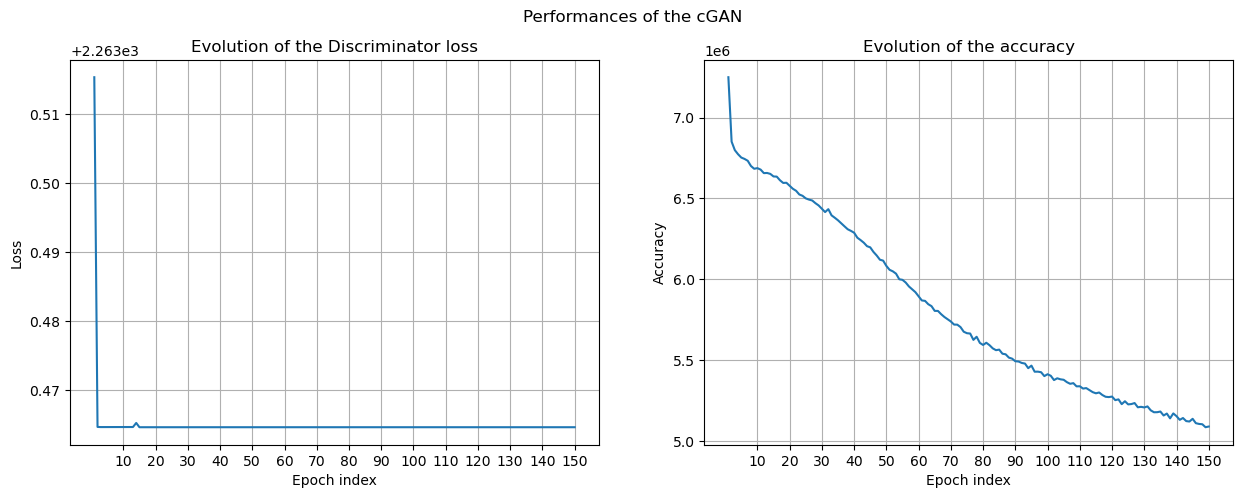

In [30]:
pkl_file_path  = "./saving/test_results.pth"
d_loss, g_loss = load_results_pkl(pkl_file_path)

plot_performances(d_loss, g_loss)

## Performances